**Spatial Autocorrelation of Open Mobile Home Parks in El Monte, CA**

This notebok explores the spatial autocorrelations of exisiting mobile home parks and demographics. The purpose is to go deeper into LA County and understand spatial trends in our data set and identify whether demographic trends are similiar in areas surronding exisiting mobile home parks. This analysis will be done at the Census block group level of El Monte, CA- the city within LA County with the most reported exisiting mobile home parks.

**Import Libraries**

In [2]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# Race populations block group data from census reporter
mhp = gpd.read_file('data/acs2019_5yr_B03002_elmonte.geojson')

In [4]:
mhp_tracts = gpd.read_file('data/tracts.geojson')

<AxesSubplot:>

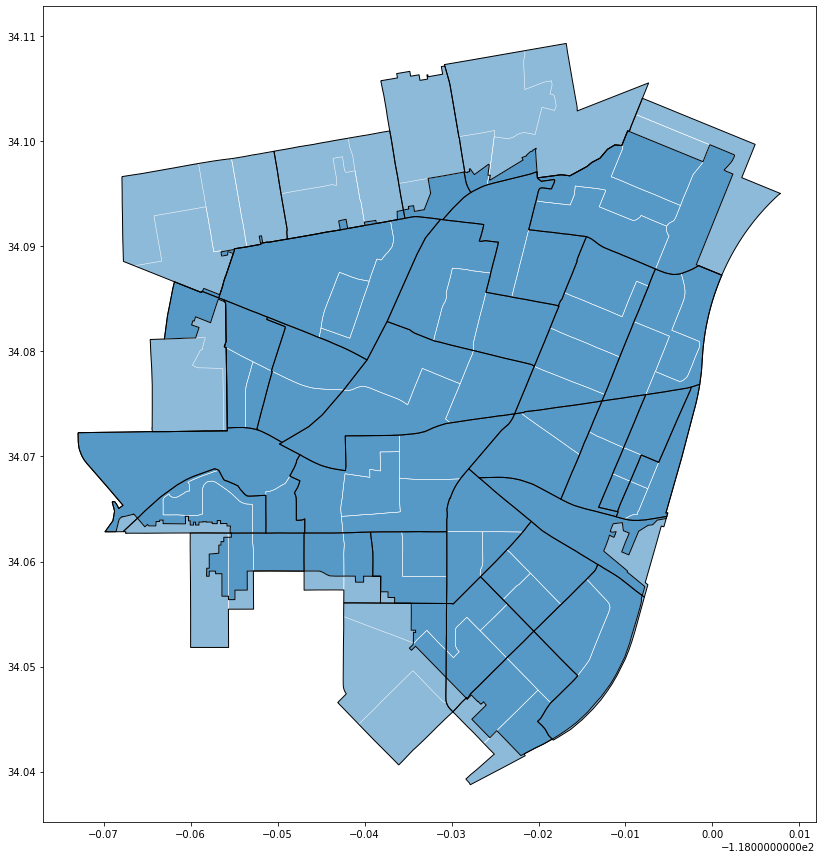

In [6]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
mhp.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

# black boundary lines of census tracts on top of everything
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

In [7]:
# total bounds
minx,miny,maxx,maxy = mhp.total_bounds

(34.238747000000004, 33.909327)

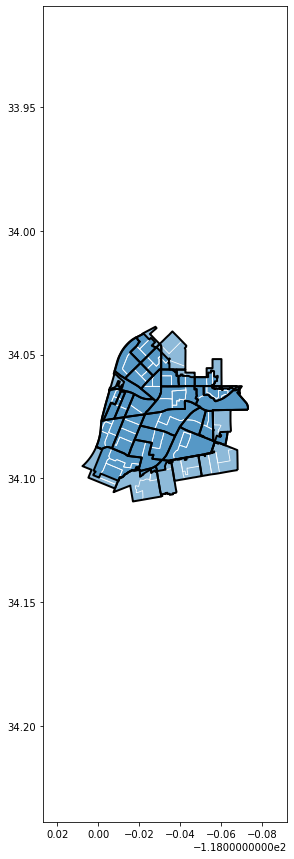

In [8]:
# compare
fig,ax = plt.subplots(figsize=(20,15))

# blue background of census tracts
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# black boundary of census tracts
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=2)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
mhp.boundary.plot(ax=ax,color='white',zorder=15,lw=0.8)

# zoom in
ax.set_xlim(minx+0.1,maxx-0.1) # zooming in just a bit
ax.set_ylim(miny+0.2,maxy-0.2)

**Data Clean Up**

In [9]:
mhp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             79 non-null     object  
 1   name              79 non-null     object  
 2   B03002001         79 non-null     float64 
 3   B03002001, Error  79 non-null     float64 
 4   B03002002         79 non-null     float64 
 5   B03002002, Error  79 non-null     float64 
 6   B03002003         79 non-null     float64 
 7   B03002003, Error  79 non-null     float64 
 8   B03002004         79 non-null     float64 
 9   B03002004, Error  79 non-null     float64 
 10  B03002005         79 non-null     float64 
 11  B03002005, Error  79 non-null     float64 
 12  B03002006         79 non-null     float64 
 13  B03002006, Error  79 non-null     float64 
 14  B03002007         79 non-null     float64 
 15  B03002007, Error  79 non-null     float64 
 16  B03002008         79

In [10]:
# trim the data to the bare minimum columns
mhp = mhp[['geoid','B03002001','geometry']]

In [11]:
# rename the columns
mhp.columns = ['FIPS','TotalPop','geometry']

In [12]:
mhp.tail()

,FIPS,TotalPop,geometry
74,15000US060374340012,2412.0,"MULTIPOLYGON (((-118.01975 34.04506, -118.0195..."
75,15000US060374340031,1485.0,"MULTIPOLYGON (((-118.02985 34.04569, -118.0294..."
76,15000US060374340032,1657.0,"MULTIPOLYGON (((-118.02835 34.03929, -118.0278..."
77,15000US060374340033,1575.0,"MULTIPOLYGON (((-118.02365 34.05082, -118.0227..."
78,16000US0622230,115517.0,"MULTIPOLYGON (((-118.07293 34.07227, -118.0728..."


In [13]:
# delete last row which is for the entire city of El monte
mhp=mhp.drop(78)

In [14]:
# fix FIPS code
mhp['FIPS'] = mhp['FIPS'].str.replace('15000US','')
mhp.tail()

,FIPS,TotalPop,geometry
73,060374340011,1998.0,"MULTIPOLYGON (((-118.02054 34.05336, -118.0198..."
74,060374340012,2412.0,"MULTIPOLYGON (((-118.01975 34.04506, -118.0195..."
75,060374340031,1485.0,"MULTIPOLYGON (((-118.02985 34.04569, -118.0294..."
76,060374340032,1657.0,"MULTIPOLYGON (((-118.02835 34.03929, -118.0278..."
77,060374340033,1575.0,"MULTIPOLYGON (((-118.02365 34.05082, -118.0227..."


Next, I'll get rid of census blocks groups with less than 20 total population. The reason why I am leaving the number so low is because based on research we know that MHP tend to be in areas not zoned residential- meaning that they are at times less dense areas. 

In [15]:
# sort by total pop
mhp.sort_values(by='TotalPop').head(20)

,FIPS,TotalPop,geometry
51,060374333063,358.0,"MULTIPOLYGON (((-118.01283 34.06567, -118.0125..."
49,060374333061,611.0,"MULTIPOLYGON (((-118.01132 34.06868, -118.0113..."
35,060374329021,721.0,"MULTIPOLYGON (((-118.06264 34.08343, -118.0624..."
53,060374333072,736.0,"MULTIPOLYGON (((-118.01104 34.06432, -118.0109..."
70,060374339021,772.0,"MULTIPOLYGON (((-118.02607 34.05393, -118.0254..."
41,060374332002,835.0,"MULTIPOLYGON (((-118.04267 34.06429, -118.0424..."
0,060374315011,857.0,"MULTIPOLYGON (((-118.03607 34.09599, -118.0357..."
2,060374315023,881.0,"MULTIPOLYGON (((-118.02916 34.10046, -118.0279..."
56,060374334012,942.0,"MULTIPOLYGON (((-118.04696 34.06034, -118.0469..."
54,060374333073,956.0,"MULTIPOLYGON (((-118.00913 34.06828, -118.0091..."


In [16]:
# delete less than 100 population geographies
mhp = mhp[mhp['TotalPop']>20]

**Census Blocks**

In [17]:
# get the layers into a web mercator projection
# reproject to web mercator
mhp = mhp.to_crs(epsg=3857)

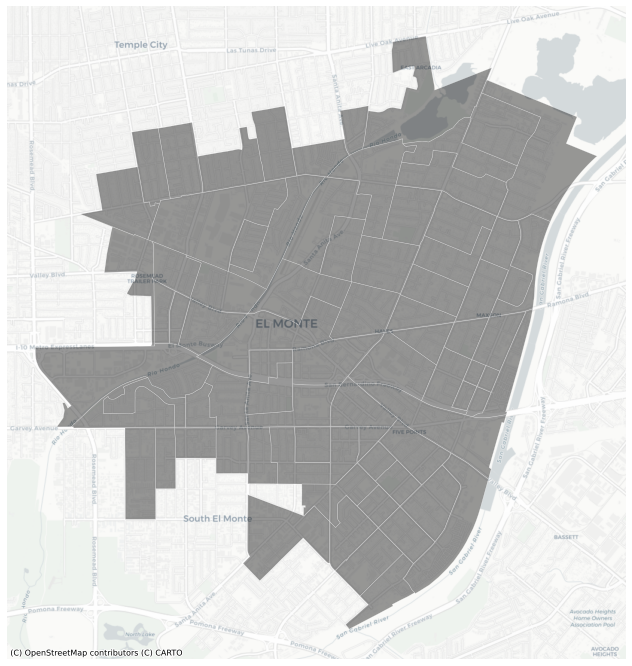

In [18]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

mhp.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**Bringing in Open Mobile Home Park Data**

In [19]:
open = gpd.read_file('data/MHP_geocoded.geojson')

In [21]:
open.shape

(374, 16)

In [24]:
open.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Park Name           374 non-null    object  
 1   County              374 non-null    object  
 2   Park Identifier     374 non-null    object  
 3   Park Address        374 non-null    object  
 4   City                374 non-null    object  
 5   Zip                 374 non-null    object  
 6   Phone               367 non-null    object  
 7   Fire Authority      374 non-null    object  
 8   Jurisdiction        374 non-null    object  
 9   MH Spaces           374 non-null    int64   
 10  RV Lots W/Drains    374 non-null    int64   
 11  RV Lots W/O Drains  374 non-null    int64   
 12  Operated by         374 non-null    object  
 13  lat                 374 non-null    float64 
 14  lon                 374 non-null    float64 
 15  geometry            374 non-null

**Trimming Data for El Monte**

In [27]:
open.City.value_counts()

 EL MONTE         29
 LANCASTER        22
 BELLFLOWER       20
 GARDENA          20
 POMONA           15
                  ..
 LYNWOOD           1
 LAKEWOOD          1
 SANTA MONICA      1
 MONTEREY PARK     1
 WEST COVINA       1
Name: City, Length: 74, dtype: int64

In [31]:
elmonte = open.City.value_counts().head(1).index.tolist()
elmonte

[' EL MONTE']

In [39]:
monte = open[open['City'] = EL MONTE]

SyntaxError: invalid syntax (3267519769.py, line 1)

In [33]:
open[open.City == ' EL MONTE'].head()

,Park Name,County,Park Identifier,Park Address,City,Zip,Phone,Fire Authority,Jurisdiction,MH Spaces,RV Lots W/Drains,RV Lots W/O Drains,Operated by,lat,lon,geometry
2,ACORN TP,LOS ANGELES,19-0009-MP,"2818 DURFEE AVE, EL MONTE, CA 91732",EL MONTE,91732,(818) 350-5235,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",20,0,0,"PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...",34.056116,-118.017002,POINT (-13137592.525 4036339.550)
6,BEL AIRE MH LODGE,LOS ANGELES,19-0051-MP,"2336 LEXINGTON AVE, EL MONTE, CA 91731",EL MONTE,91731,(310) 444-6411,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",34,0,0,"WONG ASSOCIATES, 444 S FLOWER ST, LOS ANGELES,...",34.059182,-118.038944,POINT (-13140035.153 4036751.510)
9,SHADY LANE MP,LOS ANGELES,19-0079-MP,"2532 MOUNTAIN VIEW RD, EL MONTE, CA 91731",EL MONTE,91731,(213) 585-8782,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",20,0,0,"GHUMAN, DASH, 2532 MOUNTAIN VIEW RD, EL MONTE,...",34.057399,-118.027922,POINT (-13138808.155 4036511.883)
27,FELIPE TP,LOS ANGELES,19-0218-MP,"12328 FELIPE ST, EL MONTE, CA 91732",EL MONTE,91732,(818) 448-5849,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",11,0,0,"HUANG, CHU, 2440 S HACIENDA BLVD #132, HACIEND...",34.051500,-118.021539,POINT (-13138097.624 4035719.271)
33,VICTORY TRAILER PARK,LOS ANGELES,19-0263-MP,"11208 GARVEY AVE, EL MONTE, CA 91731",EL MONTE,91731,(213) 539-2582,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",3,0,0,"JACKSON, CHOW, 3112 SEAMAN AVE, EL MONTE, CA 9...",34.062747,-118.031829,POINT (-13139243.118 4037230.473)


In [22]:
# convert pandas dataframe to geodataframe
open = gpd.GeoDataFrame(open, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(open.lon, open.lat))

In [23]:
# get the layers into a web mercator projection
# reproject to web mercator
open = open.to_crs(epsg=3857)

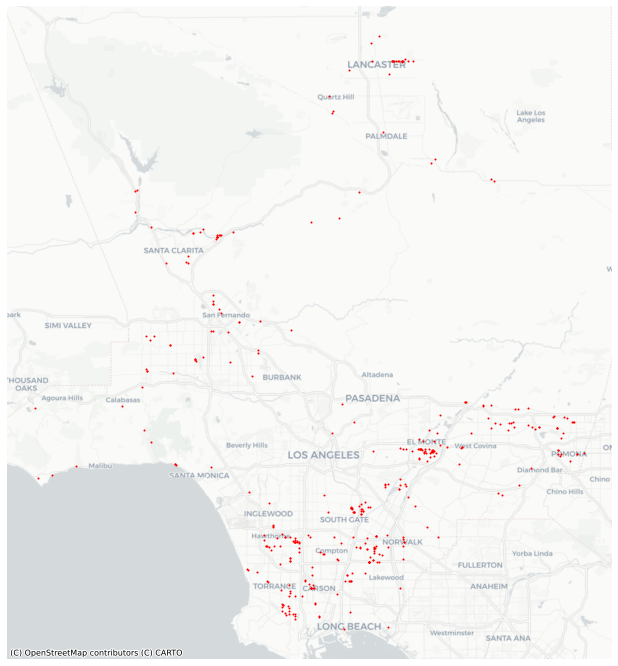

In [35]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

open.plot(ax=ax,
             color='red',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**